In [1]:
# import dill
import numpy as np
# from matplotlib import figure, gridspec
# from pathlib import Path
# from astropy.table import Table
# from astropy import units as u
# from astropy.coordinates import SkyCoord

import scanner_interpretation as scani

import healpy as hp
import pandas as pd

Init scani.Multiplets

In [2]:
bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
versions = ["hess1","hess1u"]
paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# mplets = scani.Multiplets(paths[0])
# mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
mplet_list = [scani.Multiplets(path) for path in paths]


unicorns = [9,18]
for j in unicorns:
    print(len(mplet_list[j]))
    mplet_list[j].objectifyColumns()
    print(len(mplet_list[j]))

    
mplets = mplet_list[0]
mplets.appendMultiplets(*mplet_list[1:])

17
17
134
134


Aitov scatter

In [ ]:
fig,ax = mplets.getAitoffFigure()
fig.savefig("figures/combined/aitoff.png",facecolor="white",dpi=300)

Cornerplot of the resulting multiplets

In [ ]:
# plotting mplet results
from corner import corner

fig = corner(mplets.table.to_pandas(),var_names=["Nmax","dt","da"])
fig.savefig("figures/combined/corner_center.png",facecolor="white",dpi=300)

HEALPix

/lustre/fs22/group/hess/user/wybouwt/conda/gammatransients/lib/python3.9/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/lustre/fs22/group/hess/user/wybouwt/conda/gammatransients/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


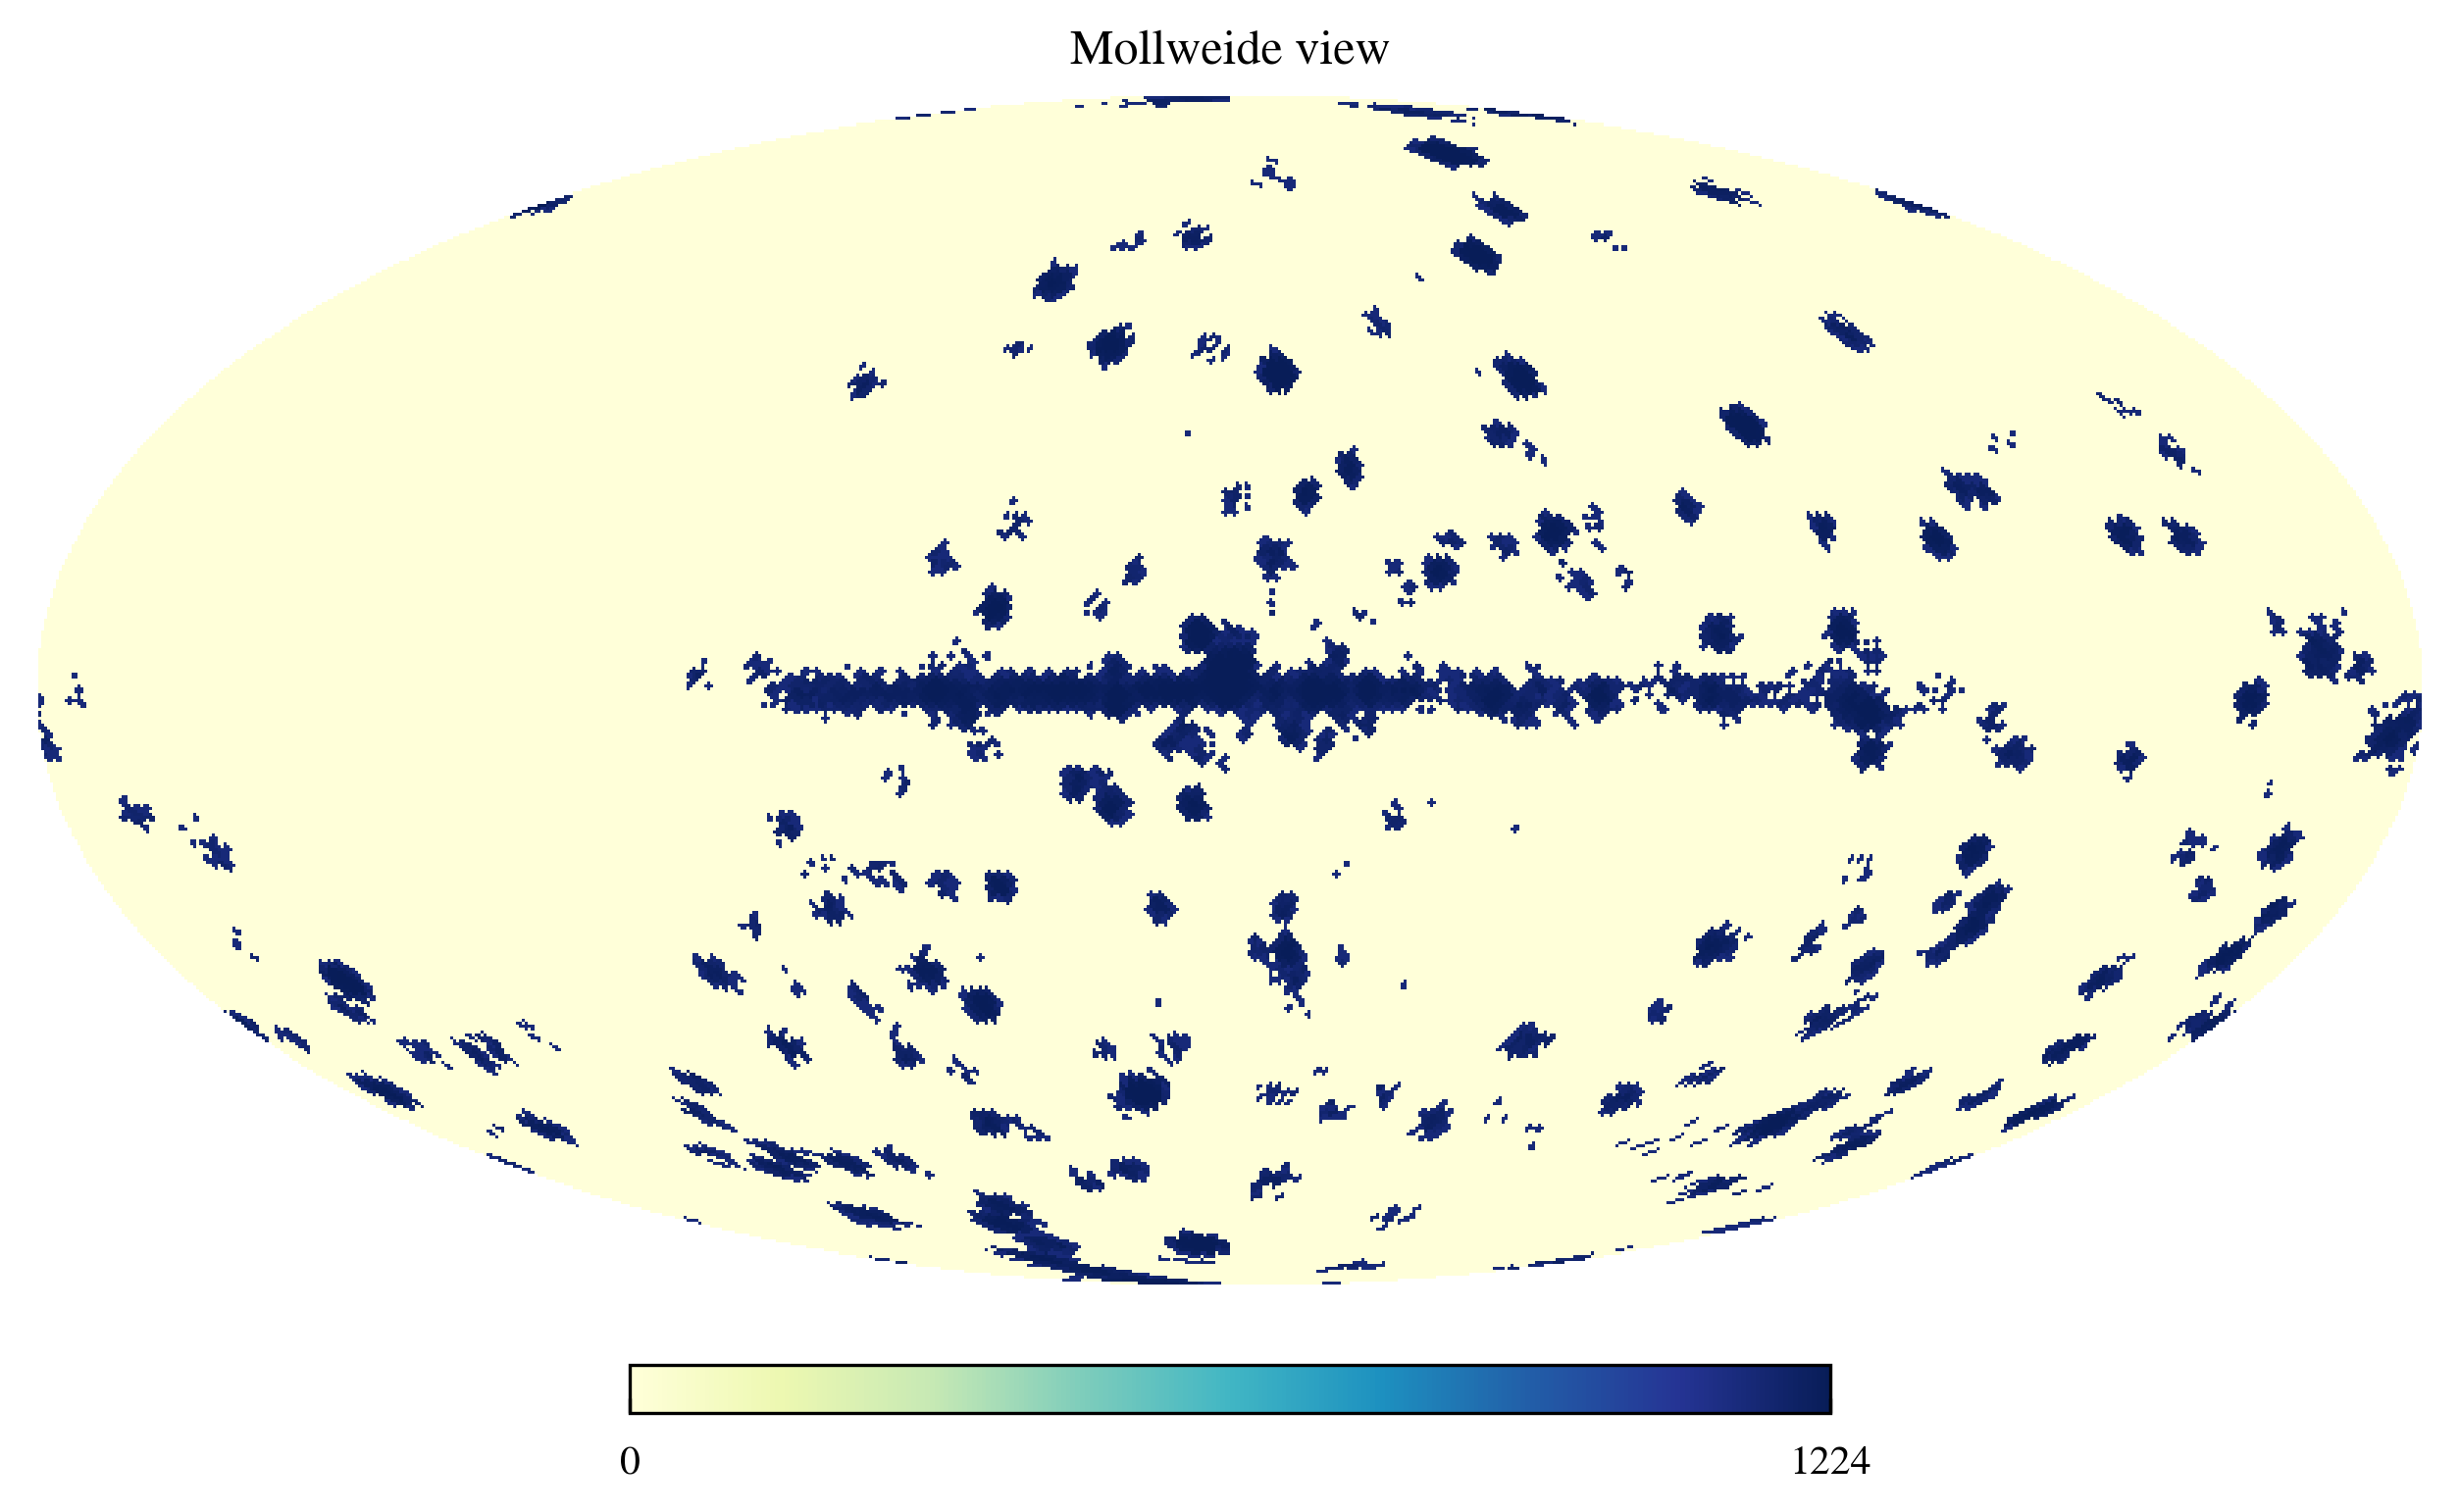

In [3]:
# mask = mplets.table["Nmax"]==5
from matplotlib import colors
m = scani.cat2hpx(mplets.table["MEDIAN_RA"],mplets.table["MEDIAN_DEC"],nside=2**6)
hp.mollview(m,norm="hist",cmap="YlGnBu")